## Produce lagrangian particules trajectories  from eNATL60 
### for H2020-EUROSEA


Lagrangian trajectories based on software Ocean Parcels: https://oceanparcels.org/

In [2]:
## standart libraries
import os,sys
import numpy as np

# xarray
import xarray as xr

# plot
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# custom tools for plotting
import lib_eurosea as slx


# for ocean parcels
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, ParticleFile
from argparse import ArgumentParser
import numpy as np
import pytest
from glob import glob
from datetime import timedelta as delta
from os import path
import time
from netCDF4 import Dataset


# for jupyter notebook display
%matplotlib inline 

## Select region to process 
(either MEDWEST or NANFL)

In [3]:
rbox='MEDWEST'
#rbox='NANFL'

## Step 1:  Ocean Parcels reads the model data (and creates the "fieldset")

In [4]:
# output directory for plots and drifters file
diro="/gpfswork/rech/egi/regi915/PLT/EUROSEA_DRIFTERS/prod/"



# input directory (for eNATL60 data files)
data_path = '/gpfsstore/rech/egi/commun/EUROSEA/eNATL60-BLB002/'

# intitial time
it0='2009-09-01T00:30:00.000000000'

# final time
itf='2009-09-07T00:30:00.000000000'

# u,v,ssh files
ufiles = sorted(glob(data_path+'eNATL60'+rbox+'-BLB002_y2009m09*.1h_vozocrtx_15m.nc'))
vfiles = sorted(glob(data_path+'eNATL60'+rbox+'-BLB002_y2009m09*.1h_vomecrty_15m.nc'))
sshfiles = sorted(glob(data_path+'eNATL60'+rbox+'-BLB002_y2009m09*.1h_sossheig.nc'))

# grid files
meshfi = 'mesh_hgr_eNATL60'+rbox+'_3.6.nc'
maskfile   =data_path+'/mask_eNATL60'+rbox+'_3.6.nc'


# now creates the Ocean PArcels "fieldset" :
# (see Ocean Parcels docs: 
# https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_nemo_curvilinear.ipynb)
filenames = {'U': {'lon': data_path + meshfi,
                   'lat': data_path + meshfi,
                   'data': ufiles},
             'V': {'lon': data_path + meshfi,
                   'lat': data_path + meshfi,
                   'data': vfiles},
            'SSH': {'lon': data_path + meshfi,
                   'lat': data_path + meshfi,
                   'data': sshfiles},}

variables = {'U': 'vozocrtx', 'V': 'vomecrty', 'SSH': 'sossheig'}

dimensions = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}

# Fieldset definition:
field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=False)

## Step 2:  Ocean Parcels builds the "particle set"

* def a new class of particle that save also the currents

In [55]:
class SampleParticle(JITParticle):         # Define a new particle class
    ssh = Variable('ssh')  # Variable 'p' initialised by sampling the pressure
    uinterp = Variable('uinterp')  
    vinterp = Variable('vinterp')    

* make initial location of the set of particules set for Barbara@IMEDA

In [56]:
if (rbox=='MEDWEST'):
    #Med box corners (in lon,lat in degrees):
    lonbb = [1.45, 2.39]
    latbb=[39.81, 40.35]
    #
    # evenly spaced lats and lons according to Barbara's request
    latpp = np.linspace(39.82, 40.34,num=7)
    lonpp = np.linspace(1.46, 2.38,num=7)

if (rbox=='NANFL'):
    #nanfl box corners (in lon,lat in degrees):
    lonbb = [-48.7, -47.82]
    latbb=[34.71, 35.25]
    #
    # evenly spaced lats and lons according to Barbara's request
    latpp = np.linspace(34.72, 35.24,num=7)
    lonpp = np.linspace(-48.6, -47.83,num=7)


# create the corresponding 2-d array
latp = np.array([latpp,latpp,latpp,latpp,latpp,latpp,latpp])
lonpT = np.array([lonpp,lonpp,lonpp,lonpp,lonpp,lonpp,lonpp])
lonp = lonpT.transpose()

# make it a vector
lonlist = lonp.flatten()
latlist = latp.flatten()

* make the set of paricles

In [57]:
pset = ParticleSet.from_list(fieldset=field_set, pclass=SampleParticle, lon=lonlist, lat=latlist,time=0)

* define new kernel to sample U, V and SSH at particle location along the trajectory (basic kernel does not sample u,v,ssh. Only outputs the trajectory (lon,lat).

## Step 3:  Add functions to the initial AdvectionRK4 kernel to sample u,v,ssh fields along the trajectories

In [58]:
k_ADVRK4 = pset.Kernel(AdvectionRK4)
    
def SampleUV(particle, fieldset, time):  # Custom function that samples fieldset.P at particle location
    (u1, v1) = fieldset.UV[time, particle.depth,particle.lat, particle.lon]
    particle.uinterp = u1
    particle.vinterp = v1

k_sampleUV = pset.Kernel(SampleUV)    # Casting the SampleP function to a kernel.

    
def SampleSSH(particle, fieldset, time):  # Custom function that samples fieldset.P at particle location
    particle.ssh = fieldset.SSH[time, particle.depth,particle.lat, particle.lon]

k_sampleSSH = pset.Kernel(SampleSSH)    # Casting the SampleP function to a kernel.


## Step 4:   Run Ocean Parcels to compute lagrangian trajectories based on the fieldset and particle set built above

In [59]:
# start time of the computation
start = time.time()

# name of output file
filo=rbox+"-EUROSEA_49p_6d_freq15min_start_09-2009"

# define the characteristics of the particle file (the trajectories)
pfile = ParticleFile(diro+filo, pset, outputdt=delta(hours=0.25))

# compute with the kernel defined above
pset.execute(k_ADVRK4+k_sampleSSH+k_sampleUV, runtime=delta(days=6), dt=delta(hours=0.25), output_file=pfile)

# display time of computation
end = time.time()
print(end-start)

# save output to netcdf
pfile.export()

INFO: Compiled SampleParticleAdvectionRK4SampleSSHSampleUV ==> /tmp/parcels-43033/9baaeec2d3e0632204b7a7fc9ad27c30_0.so
INFO: Temporary output files are stored in /gpfswork/rech/egi/regi915/PLT/EUROSEA_DRIFTERS/prod/out-LATSCOJT.
INFO: You can use "parcels_convert_npydir_to_netcdf /gpfswork/rech/egi/regi915/PLT/EUROSEA_DRIFTERS/prod/out-LATSCOJT" to convert these to a NetCDF file during the run.
100% (518400.0 of 518400.0) |############| Elapsed Time: 0:01:08 Time:  0:01:08


83.9349410533905


Note: at this stage, your particle file is already computed and saved, so most of the work is done. But u,v sampled are in deg/s which is not very convenient for later use. The next step will be to convert the sampled u,v into m/s unit.
(see https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_unitconverters.ipynb )

## Step 5:   Read the saved trajectories (just computed above)  and convert sampled u,v to m/s for convenience.

(see https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_unitconverters.ipynb )

In [5]:
# read the particle file (trajectories)
filo2=rbox+"-EUROSEA_49p_6d_freq15min_start_09-2009"


data_xarray2 = xr.open_dataset(diro+filo2+'.nc')
print(data_xarray2)

<xarray.Dataset>
Dimensions:     (obs: 577, traj: 49)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    ssh         (traj, obs) float32 ...
    uinterp     (traj, obs) float32 ...
    vinterp     (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2.dev0+g9a5c0ee9.d20210105
    parcels_mesh:           spherical


* __plot ssh for quick check:__

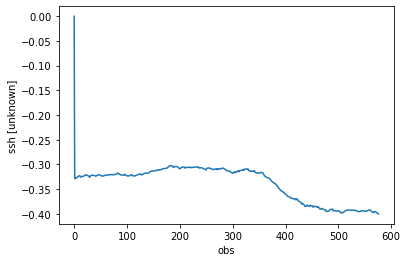

In [61]:
data_xarray2.isel(traj=0)['ssh'].plot()

* __convert v to from deg/s to m/s:__

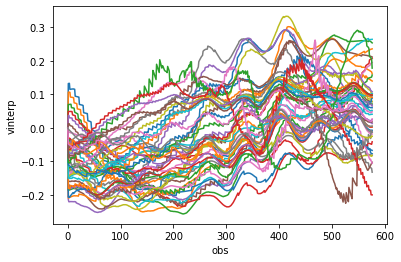

In [62]:
# conversion factor:
cconv=1852.*60.

# apply
v_convert = cconv*data_xarray2['vinterp']

# plot for quick check
for itr in range(0,48):
        v_convert.isel(traj=itr).plot()

* __convert u to from deg/s to m/s:__

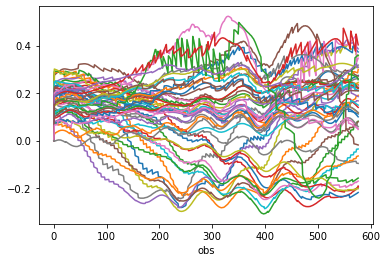

In [63]:
# apply conversion factor
u_convert = cconv*data_xarray2['uinterp']
lattruc = (np.pi/180.)*data_xarray2['lat']
latconv = np.cos(lattruc)
u_convert = u_convert*latconv

# plot for quick check:
for itr in range(0,48):
        u_convert.isel(traj=itr).plot()

* __rewrite file with units for currents in deg/s and additionnal variable u,v in m/s:__

In [64]:
# add 'units' attributes
data_xarray2.uinterp.attrs['units']='deg/s'
data_xarray2.vinterp.attrs['units']='deg/s'

In [65]:
# output file name
outfi=filo2+"_c"

# save
data_xarray2.to_netcdf(diro+outfi+'.nc',mode='w')

In [66]:
# add attributes  for new variable u_convert (u converted in m/s)
u_convert.name='u_convert'
u_convert.attrs['standard_name']='u'
u_convert.attrs['units']='m/s'
u_convert.attrs['long_name']='zonal current at particle location'
# save
u_convert.to_netcdf(diro+outfi+'.nc',mode='a')

# add attributes  for new variable u_convert (u converted in m/s)
v_convert.name='v_convert'
v_convert.attrs['standard_name']='v'
v_convert.attrs['units']='m/s'
v_convert.attrs['long_name']='meridional current at particle location'
# save
v_convert.to_netcdf(diro+outfi+'.nc',mode='a')

---
---
## Step 6:   Plot the trajectories

In [7]:
# read the final particle file (trajectories)
outfi=filo2+"_c"
data_xarray3 = xr.open_dataset(diro+outfi+'.nc')
print(data_xarray3)

<xarray.Dataset>
Dimensions:     (obs: 577, traj: 49)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    ssh         (traj, obs) float32 ...
    uinterp     (traj, obs) float32 ...
    vinterp     (traj, obs) float32 ...
    u_convert   (traj, obs) float64 ...
    v_convert   (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2.dev0+g9a5c0ee9.d20210105
    parcels_mesh:           spherical


* __Quick and dirty plot to visualize the trajectories and starting locations:__

[]

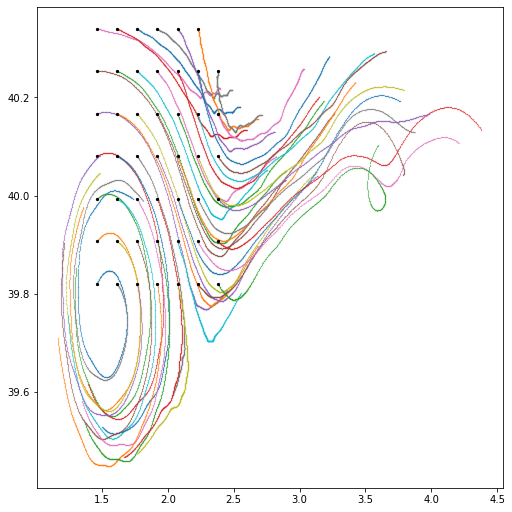

In [8]:
fig, (ax1) = plt.subplots(1,1,figsize=(7,7),constrained_layout=True)

for itr in range(0,48):
    ax1.scatter(data_xarray3.isel(traj=itr)['lon'].T,data_xarray3.isel(traj=itr)['lat'].T, marker='.',s=0.2)
    ax1.scatter(data_xarray3.isel(traj=itr,obs=0)['lon'].T,data_xarray3.isel(traj=itr,obs=0)['lat'].T, marker='o',s=5,color='k')

#plt.xlim(0,2)
#plt.ylim(36,38)
plt.plot()

# Save fig in png, resolution dpi    
#slx.saveplt(fig,diro,'quickplot_rajzoom.png',dpifig=300)
#plt.close(fig)

* __now for a "nicer" plot, we read the gridded SSH and U,V fields to plot the background__

In [9]:
# Read U15m

varna='vozocrtx'

# mask
maskvar='umask'
maskU3d =  xr.open_dataset(maskfile)[maskvar]
maskU = maskU3d[0,0,:,:]

# longitude
nav_lon_refU = xr.open_dataset(maskfile)['nav_lon']
# latitude
nav_lat_refU = xr.open_dataset(maskfile)['nav_lat']

REGU   = xr.open_mfdataset(ufiles,concat_dim='time_counter',decode_times=True)[varna].squeeze()

In [10]:
# Read V15m

varna='vomecrty'

# mask
maskvar='vmask'
maskV3d =  xr.open_dataset(maskfile)[maskvar]
maskV = maskV3d[0,0,:,:]

# longitude
nav_lon_refV = xr.open_dataset(maskfile)['nav_lon']
# latitude
nav_lat_refV = xr.open_dataset(maskfile)['nav_lat']

REGV   = xr.open_mfdataset(vfiles,concat_dim='time_counter',decode_times=True)[varna].squeeze()

In [11]:
# read SSH

varna='sossheig'

# mask
maskvar='tmask'
maskT3d =  xr.open_dataset(maskfile)[maskvar]
maskSSH = maskT3d[0,0,:,:]

# longitude
nav_lon_refSSH = xr.open_dataset(maskfile)['nav_lon']
# latitude
nav_lat_refSSH = xr.open_dataset(maskfile)['nav_lat']

REGSSH   = xr.open_mfdataset(sshfiles,concat_dim='time_counter',decode_times=True)[varna]

* __plot the initial location of the 49 particles (following request from Barbara IMEDEA)__

In [12]:
# select fields (ssh, u) to plot at initial time
it=it0
var2plot = REGSSH.sel(time_counter=it).where(maskSSH>0)

#  U, V are used to add some grey shadding on the map
gradvar2plotU = -1.0*REGU.sel(time_counter=it).where(maskU>0).squeeze()
gradvar2plotU = gradvar2plotU.where((nav_lon_refU>0)|((nav_lon_refU<0)&(nav_lat_refU<40)))

gradvar2plotV = -1.0*REGV.sel(time_counter=it).where(maskV>0).squeeze()
gradvar2plotV = gradvar2plotV.where((nav_lon_refV>0)|((nav_lon_refV<0)&(nav_lat_refV<40)))

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


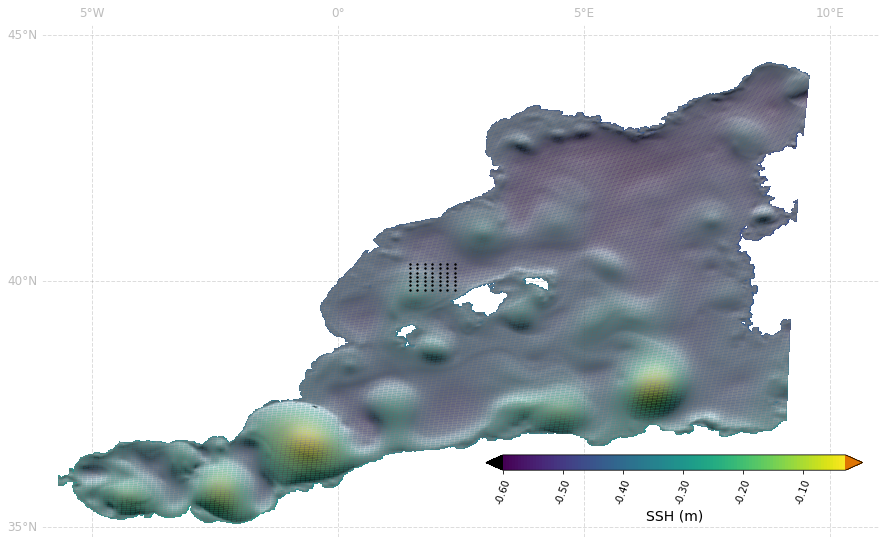

In [14]:
# plot:

if (rbox=="MEDWEST"):
    xlim=(-6,11)
    ylim=(34.8,45.2)

if (rbox=="NANFL"):
    xlim=(-55.,-40.)
    ylim=(29.6,40.1)
    
#lonU = 360.+nav_lon_refU
#lonssh= 360.+nav_lon_refSSH

alpha=0.2
#========= Plot settings ===============

#========= Plot settings ===============

if (rbox=="MEDWEST"):
    levbounds=[-0.6,-0.025,0.005]
    levbounds2=[-0.99,0.69,0.01]

if (rbox=="NANFL"):
    levbounds=[-0.7,0.65,0.005]
    levbounds2=[-1.4,1.5,0.01]


# customed colormap
cmap,norm = slx.mycolormap(levbounds,cm_base='viridis',cu='k',co='#DF7401')
#  customed colormap in greys for the additional shading
cmap2,norm2 = slx.mycolormap(levbounds2,cm_base='Greys',cu='k',co='r')


#========= PLOT ===============
fig3,(ax) = plt.subplots(1, 1, figsize=[15, 15],facecolor='w')
# main plot
cs,ax = slx.plotmapMEDWEST(fig3,ax,var2plot,nav_lon_refSSH,nav_lat_refSSH,cmap,norm,xlim=xlim,ylim=ylim)

# add grey shading to make plot nicer and sharpen the gradient features to the eye
cs2   = plt.pcolormesh(nav_lon_refU,nav_lat_refU,gradvar2plotU,cmap=cmap2,norm=norm2,transform=ccrs.PlateCarree(),alpha=alpha)

# add initial location of the particles
cs3   = plt.scatter(data_xarray3.isel(obs=0)['lon'].T,data_xarray3.isel(obs=0)['lat'].T,color='k',s=2,marker='o',zorder=10)


tlabel='SSH (m)'
cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=20,tformat="%.2f",
                             tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(0.08, -0.04,0.9,0.2))

plt.show()

# Save fig in png, resolution dpi    
slx.saveplt(fig3,diro,'PLTTRAJ_t0_'+str(alpha)+'_'+filo2+'.png',dpifig=300)
plt.close(fig3)

* __plot the trajectories on a zoom of the subregion__

In [76]:
# select fields to plot

# SSH plotted as the mean over the 6-day time period
var2plot = REGSSH.sel(time_counter=slice(it0,itf)).mean(dim='time_counter').where(maskSSH>0)

#  U, V are used to add some grey shadding on the map
gradvar2plotU = -1.0*REGU.sel(time_counter=slice(it0,itf)).mean(dim='time_counter').where(maskU>0).squeeze()
gradvar2plotU = gradvar2plotU.where((nav_lon_refU>0)|((nav_lon_refU<0)&(nav_lat_refU<40)))


In [82]:
gradvar2plotU.max().values

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/parcels/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(0.64629704, dtype=float32)

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


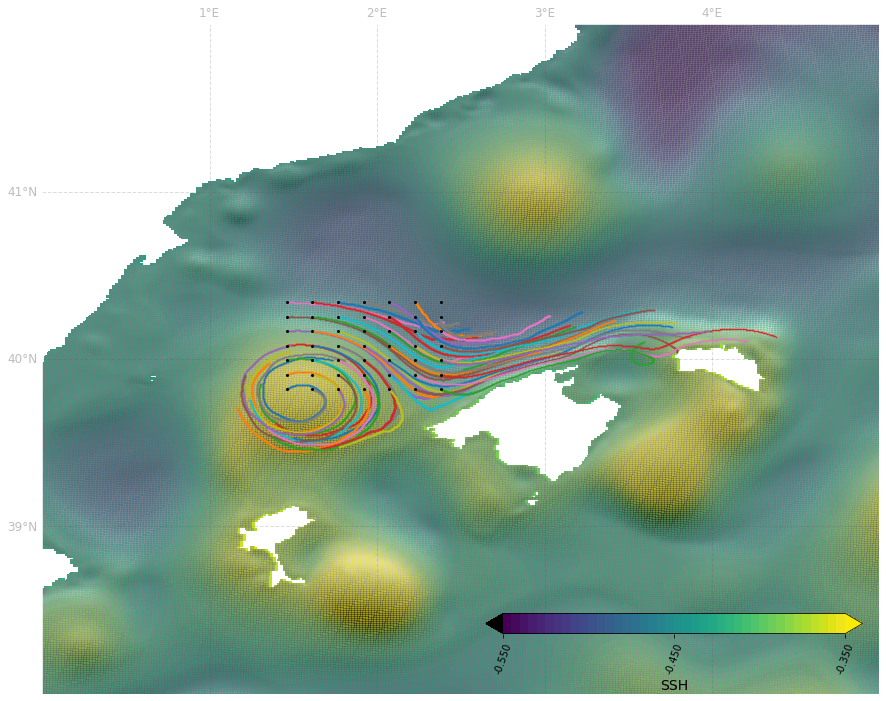

In [96]:
# plot:

xlim=(0,5.0)
ylim=(38.,42)


if (rbox=="MEDWEST"):
    xlim=(0,5.0)
    ylim=(38.,42)

if (rbox=="NANFL"):
    xlim=(-51.5,-47.5)
    ylim=(33,37)



alpha=0.4
#========= Plot settings ===============

if (rbox=="MEDWEST"):
    levbounds=[-0.55,-0.35,0.005]
    levbounds2=[-0.95,0.65,0.01]

if (rbox=="NANFL"):
    levbounds=[-0.32,0.4,0.005]
    levbounds2=[-1.4,0.9,0.01]


# customed colormap for ssh
cmap,norm = slx.mycolormap(levbounds,cm_base='viridis',cu='k',co='#f9eb08')
#  customed colormap in greys for the additional shading
cmap2,norm2 = slx.mycolormap(levbounds2,cm_base='Greys',cu='y',co='k')


#========= PLOT ===============
fig3,(ax) = plt.subplots(1, 1, figsize=[15, 15],facecolor='w')
# main plot
cs,ax = slx.plotmapMEDWEST(fig3,ax,var2plot,nav_lon_refSSH,nav_lat_refSSH,cmap,norm,xlim=xlim,ylim=ylim,incrgridlon=1,incrgridlat=1)

# add grey shading to make plot nicer and sharpen the gradient features to the eye
cs2   = plt.pcolormesh(nav_lon_refU,nav_lat_refU,gradvar2plotU,cmap=cmap2,norm=norm2,transform=ccrs.PlateCarree(),alpha=alpha)

# add location of particles at initial time
cs3   = plt.scatter(data_xarray3.isel(obs=0)['lon'].T,data_xarray3.isel(obs=0)['lat'].T,color='k',s=4,marker='o',zorder=11)

# add trajectories along the 6-day period
for itr in range(0,48):
    plt.scatter(data_xarray3.isel(traj=itr)['lon'].T,data_xarray3.isel(traj=itr)['lat'].T, marker='.',s=1,zorder=10)

cbon=True
if cbon:
    tlabel='SSH'
    cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=20,tformat="%.3f",
                                 tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                                bbta=(0.08, -0.08,0.9,0.2))

plt.show()



# Save fig in png, resolution dpi    
slx.saveplt(fig3,diro,'PLTTRAJ_allt_zoom_'+str(alpha)+'_'+filo2+'.png',dpifig=300)
plt.close(fig3)